# Logistic Regression and Random Forest Classifier Test
## Author: Ethan Cramer

### Classes:
0.  Acoustic/Folk
1.  Alt Music
2.  Blues
3.  Bollywood
4.  Country
5.  HipHop
6.  Indie Alt
7.  Instrumental
8.  Metal
9.  Pop
10. Rock

In [1]:
import matplotlib.pyplot as plt
from math import sqrt, isnan
import pandas as pd
import numpy as np

In [41]:
# Load Dataset
from sklearn.model_selection import train_test_split

dataset = pd.read_csv("Kaggle dataset/train.csv")

# Use this to filter features that you might not want
feature_columns = ['Popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                    'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms', 'time_signature']

# Feel free to adjust the test_size, random_state, and columns that should be used.
X_train, X_test, y_train, y_test = train_test_split(dataset[feature_columns], dataset['Class'], 
                                                    test_size=0.2, random_state=42)

# If the model that you are using doesn't split the training set into a validation set, here is a basic holdout set for validation that is commented out by default
# X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [42]:
# Preprocessing

# Combining Alt Music, Indie Alt, and Rock
y_train = y_train.replace(to_replace=[1, 6], value=10)
y_test = y_test.replace(to_replace=[1, 6], value=10)

# Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp_mean = IterativeImputer(random_state=42)
imp_mean.fit(X_train)

X_train = imp_mean.transform(X_train)
X_test = imp_mean.transform(X_test)

# Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Combining Features
#from sklearn.pipeline import FeatureUnion
#from sklearn.decomposition import PCA, TruncatedSVD

#union = FeatureUnion([("pca", PCA(n_components=1)), ("svd", TruncatedSVD(n_components=2))])
#union.fit(X_train)

#X_train = union.transform(X_train)
#X_test = union.transform(X_test) 


In [43]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier

rfc_1 = RandomForestClassifier()
rfc_1.fit(X_train, y_train)

print(rfc_1.score(X_test, y_test))

rfc_2 = OneVsOneClassifier(RandomForestClassifier()) 
rfc_2.fit(X_train, y_train)

print(rfc_2.score(X_test, y_test))

0.6783333333333333
0.6786111111111112


In [44]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier

lrc_1 = LogisticRegression(solver='lbfgs', max_iter=300) 
lrc_1.fit(X_train, y_train)

print(lrc_1.score(X_test, y_test))

lrc_2 = LogisticRegression(solver='liblinear')
lrc_2.fit(X_train, y_train)

print(lrc_2.score(X_test, y_test))

E:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6361111111111111
0.6236111111111111


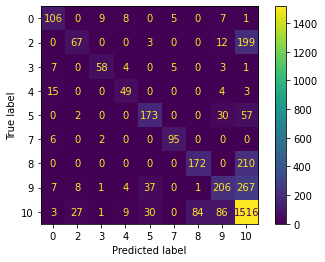

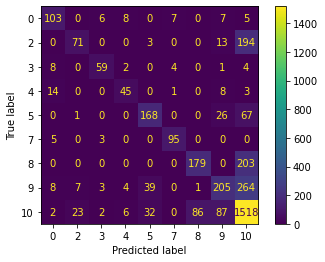

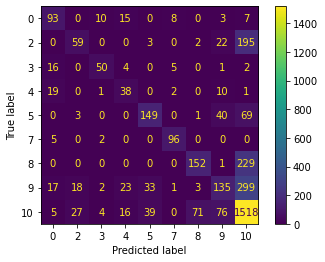

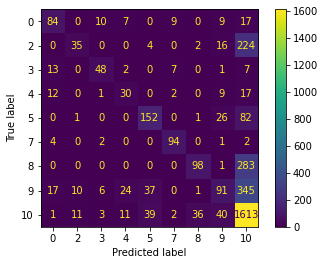

In [45]:
# Metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Worst Performers: 1 < 6 < 2 < 9 < 8 < 10
# Tends to predict 'Alt_Music' as 'Indie Alt' and 'Rock'
# Half of 'Blues' is predicted as 'Rock'dataset
# 'Indie Rock' frequently predicted as 'Rock'
# 'Metal' frequently predicted as 'Rock'
predictions = rfc_1.predict(X_test) 
cm1 = confusion_matrix(y_test, predictions, labels = rfc_1.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=rfc_1.classes_)
disp1.plot()

predictions = rfc_2.predict(X_test) 
cm2 = confusion_matrix(y_test, predictions, labels = rfc_2.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=rfc_2.classes_)
disp2.plot()
plt.show()

predictions = lrc_1.predict(X_test) 
cm3 = confusion_matrix(y_test, predictions, labels = lrc_1.classes_)
disp3 = ConfusionMatrixDisplay(confusion_matrix=cm3, display_labels=lrc_1.classes_)
disp3.plot()
plt.show()

predictions = lrc_2.predict(X_test) 
cm4 = confusion_matrix(y_test, predictions, labels = lrc_2.classes_)
disp4 = ConfusionMatrixDisplay(confusion_matrix=cm4, display_labels=lrc_2.classes_)
disp4.plot()
plt.show()

In [49]:
# Grid Search for Logistic Regression
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedShuffleSplit

C_range = np.logspace(-5, 5, 13) # 10^-5 to 10^5

# Model using default parameters
default_lr = LogisticRegression(solver='lbfgs', max_iter=300)
print("Default Validation Accuracy is %0.3f" % (np.mean(cross_val_score(default_lr, X_train, y_train, cv=5))))

# Exhaustive grid search to find the hyperparameters that give the highest accuracy
tuned_parameters = dict(C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(LogisticRegression(solver='lbfgs', max_iter=300), param_grid=tuned_parameters, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.3f" % (grid.best_params_, grid.best_score_))

# Model using highest accuracy parameters
tuned_lr = LogisticRegression(solver='lbfgs', max_iter=300, C=grid.best_params_['C'])
print("Tuned Validation Accuracy is %0.3f" % (np.mean(cross_val_score(tuned_lr, X_train, y_train, cv=5))))

tuned_lr.fit(X_train, y_train)
print("Final Test Set Accuracy is %0.3f" % tuned_lr.score(X_test, y_test))

Default Validation Accuracy is 0.495


E:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:\Python\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
E:

The best parameters are {'C': 1.0} with a score of 0.500
Tuned Validation Accuracy is 0.495
Final Test Set Accuracy is 0.482


In [46]:
# Grid Search for Random Forest
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # n_estimators: 10^0 to 10^5
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Model using default parameters
default_rf = RandomForestClassifier()
print("Default Validation Accuracy is %0.3f" % (np.mean(cross_val_score(default_rf, X_train, y_train, cv=5))))

# Exhaustive grid search to find the hyperparameters that give the highest accuracy
#cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = RandomizedSearchCV(RandomForestClassifier(), random_grid, random_state=0)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.3f" % (grid.best_params_, grid.best_score_))

# Model using highest accuracy parameters
tuned_rf = RandomForestClassifier(n_estimators=grid.best_params_['n_estimators'])
print("Tuned Validation Accuracy is %0.3f" % (np.mean(cross_val_score(tuned_rf, X_train, y_train, cv=5))))

tuned_rf.fit(X_train, y_train)
print("Final Test Set Accuracy is %0.3f" % tuned_rf.score(X_test, y_test))

Default Validation Accuracy is 0.681
The best parameters are {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True} with a score of 0.690
Tuned Validation Accuracy is 0.685
Final Test Set Accuracy is 0.678


# Random Forest Randomized Search:
* Default Validation Accuracy is 0.500
* The best parameters are {'n_estimators': 600, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False} with a score of 0.520
* Tuned Validation Accuracy is 0.509
* Final Test Set Accuracy is 0.504

* Default Validation Accuracy is 0.681
* The best parameters are {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': True} with a score of 0.690
* Tuned Validation Accuracy is 0.685
* Final Test Set Accuracy is 0.678